# DROPOUT

In [1]:
import d2l 
from mxnet import * 
npx.set_np()

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    
    if dropout == 1:
        return np.zeros_like(X)
    
    if dropout == 0:
        return X
    
    mask = np.random.uniform(0, 1, X.shape) > dropout
    
    return mask.astype(np.float32) * X / (1.0 - dropout)

In [3]:
X = np.arange(16).reshape(2, 8)

print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  2.  4.  6.  8. 10. 12. 14.]
 [ 0. 18. 20.  0.  0.  0. 28.  0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### DEF MODEL PARAMETERS

In [4]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

w1 = np.random.normal(scale= 0.01, size= (num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)

w2 = np.random.normal(scale= 0.01, size= (num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)

w3 = np.random.normal(scale= 0.01, size= (num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

In [5]:
params = [w1, b1, w2, b2, w3, b3]

for param in params:
    param.attach_grad()

### DEF MODEL

In [8]:
dropout1, dropout2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, w1) + b1)
    
    if autograd.is_training():
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, w2) + b2)
    
    if autograd.is_training():
        H2 = dropout_layer(H2, dropout2)
    return np.dot(H2, w3) + b3

### TRAINING AND TESTING

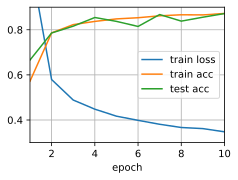

In [9]:
num_epochs, lr, batch_size = 10, 0.5, 256

loss = gluon.loss.SoftmaxCrossEntropyLoss()

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, 
             lambda batch_size: d2l.sgd(params, lr, batch_size))

### CONCISE IMPLEMENTATION

In [11]:
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Dense(256, activation= 'relu'),
       nn.Dropout(dropout1),
       nn.Dense(256, activation='relu'),
       nn.Dropout(dropout2),
       nn.Dense(10))

net.initialize(init.Normal(sigma= 0.01))

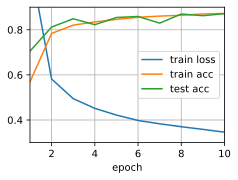

In [12]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## VANISHING GRADIENT

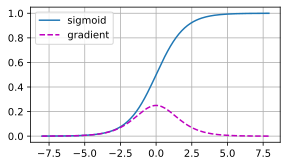

In [13]:
x = np.arange(-8.0, 8.0, 0.1)
x.attach_grad()

with autograd.record():
    y = npx.sigmoid(x)
y.backward()

d2l.plot(x, [y, x.grad], legend= ['sigmoid', 'gradient'], figsize=(4.5, 2.5))

## EXPLOIDING GRADIENT

In [14]:
M = np.random.normal(size= (4,4))
print('A single matrix', M)

for i in range(100):
    M = np.dot(M, np.random.normal(size=(4,4)))

print('after multiplying 100 matrices', M)

A single matrix [[ 1.147148   -1.3778652  -0.9676628  -0.05932836]
 [-0.01199374  0.26558164 -1.1098089  -0.04214596]
 [ 0.02015271  0.20825802  0.4993376   0.62557775]
 [ 1.74355     0.35422802 -0.5343372  -0.15725483]]
after multiplying 100 matrices [[-6.29211357e+26  8.92280263e+25  8.85474632e+26  6.78972039e+26]
 [ 6.43057704e+26 -9.11915623e+25 -9.04960371e+26 -6.93913385e+26]
 [ 2.15190419e+26 -3.05160175e+25 -3.02832579e+26 -2.32208574e+26]
 [ 8.31346351e+26 -1.17892625e+26 -1.16993457e+27 -8.97092834e+26]]
